In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from scipy.stats import linregress

In [ ]:
data = pd.read_hdf('national survey of family growth.hdf5')
data.head()

,caseid,outcome,birthwgt_lb1,birthwgt_oz1,prglngth,nbrnaliv,agecon,agepreg,hpagelb,wgt2013_2015
0,60418,1,5.0,4.0,40,1.0,2000,2075.0,22.0,3554.964843
1,60418,1,4.0,12.0,36,1.0,2291,2358.0,25.0,3554.964843
2,60418,1,5.0,4.0,36,1.0,3241,3308.0,52.0,3554.964843
3,60419,6,NaN,NaN,33,NaN,3650,NaN,NaN,2484.535358
4,60420,1,8.0,13.0,41,1.0,2191,2266.0,24.0,2903.782914


In [ ]:
data.columns

Index(['caseid', 'outcome', 'birthwgt_lb1', 'birthwgt_oz1', 'prglngth',
       'nbrnaliv', 'agecon', 'agepreg', 'hpagelb', 'wgt2013_2015'],
      dtype='object')

#### ***birthwgt_lb1*** contains the ***pound part in birth weight***, ***birthwgt_oz1*** contains the ***ounce part in birth weight***.
#### So, Let's rename  ***birthwgt_lb1*** to ***pound*** and ***birthwgt_oz1*** to ***ounce*** for better consistency.

In [ ]:
data = data.rename( columns= {"birthwgt_lb1":"pound", "birthwgt_oz1":"ounce"})

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9358 entries, 0 to 9357
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   caseid        9358 non-null   int64  
 1   outcome       9358 non-null   int64  
 2   pound         6485 non-null   float64
 3   ounce         6391 non-null   float64
 4   prglngth      9358 non-null   int64  
 5   nbrnaliv      6485 non-null   float64
 6   agecon        9358 non-null   int64  
 7   agepreg       9109 non-null   float64
 8   hpagelb       6485 non-null   float64
 9   wgt2013_2015  9358 non-null   float64
dtypes: float64(6), int64(4)
memory usage: 804.2 KB


#### We have 9358 sample, one row for each pregnancy in the survey.
#### There're alot of missingness in the ***pound***, ***ounce***, ***nbrnaliv***, ***agepreg***, ***hpagelb*** columns.
#### But for better eye view let's visualize missingness.

/usr/local/lib/python3.7/dist-packages/missingno/missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  "Plotting a sparkline on an existing axis is not currently supported. "


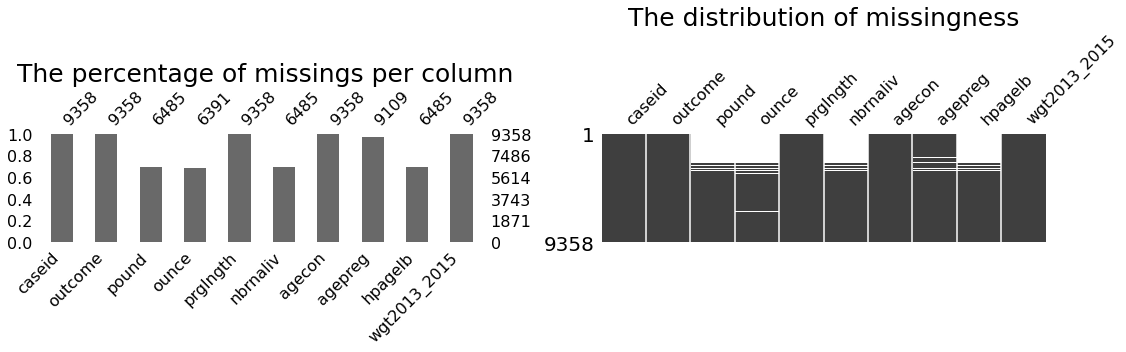

In [ ]:
#make a copy from our dataset soreted by prglngth column
newdata=data.sort_values(by="prglngth")

fig=plt.figure(figsize=(16,5))
ax1=fig.add_subplot(1,2,1)
ax1.set_title(" The percentage of missings per column", fontsize=25)
msno.bar(newdata,ax=ax1)
ax2=fig.add_subplot(1,2,2)
ax2.set_title(" The distribution of missingness ", fontsize=25)
msno.matrix(newdata, ax=ax2)
plt.tight_layout()

##### As we can observe through the distribution-of-missingness, ***Missing-at-random-data***, as there is a ***systematic-relationship*** between missingness, as the missing values are in ***the same samples***, 
##### Especially in ***very short pregnancy periods*** which means that a **miscarriage** may have occurred in this case.
##### So, We're going to drop missingness, but we keep a copy, as it may contains useful information.  

In [ ]:
newdata= data.copy()
data.dropna(inplace=True)
# We can drop caseid column as it makes no difference
data.drop("caseid", axis=1, inplace=True)

In [ ]:
data.describe()

,outcome,pound,ounce,prglngth,nbrnaliv,agecon,agepreg,hpagelb,wgt2013_2015
count,6391.0,6391.000000,6391.000000,6391.000000,6391.000000,6391.000000,6391.000000,6391.000000,6391.000000
mean,1.0,6.717572,7.213895,38.475512,1.018151,2444.362072,2515.958848,28.949147,10915.523607
std,0.0,1.829390,8.254885,2.626515,0.161126,564.857020,564.800350,10.188217,11535.986654
min,1.0,0.000000,0.000000,13.000000,1.000000,950.000000,1025.000000,5.000000,1859.105000
25%,1.0,6.000000,3.000000,38.000000,1.000000,1991.000000,2066.000000,23.000000,4361.184842
50%,1.0,7.000000,6.000000,39.000000,1.000000,2375.000000,2441.000000,27.000000,7157.980124
75%,1.0,8.000000,11.000000,40.000000,1.000000,2850.000000,2916.000000,33.000000,12938.812877
max,1.0,98.000000,99.000000,48.000000,8.000000,4208.000000,4283.000000,99.000000,75399.410000


##### we can observe that ***pound*** and ***ounce*** columns have ***minimum Zero*** and ***maximum 99*** !! this does't make any sense, this's obviously an ***error*** and we have to deal with.
##### But for better itution let's visualize it.

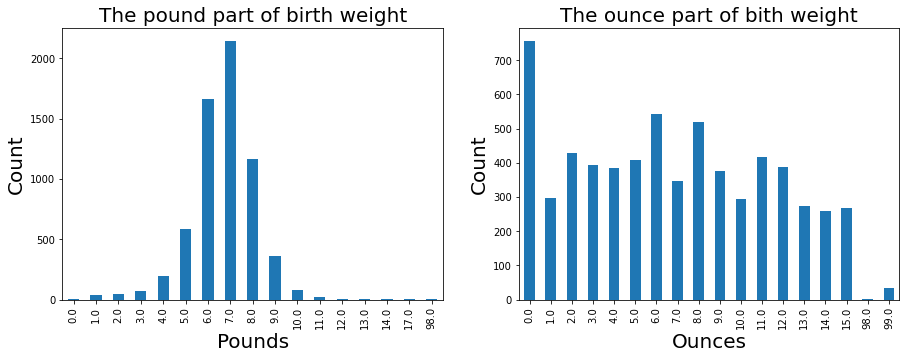

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
data["pound"].value_counts().sort_index().plot(kind="bar")
plt.title("The pound part of birth weight", fontsize=20)
plt.xlabel("Pounds", fontsize=20)
plt.ylabel("Count", fontsize=20)

plt.subplot(1,2,2)
data["ounce"].value_counts().sort_index().plot(kind="bar")
plt.title("The ounce part of bith weight", fontsize=20)
plt.xlabel("Ounces", fontsize=20)
plt.ylabel("Count", fontsize=20)

plt.show()

##### The most frequent values are ***6-8 pounds***
##### There are some ***very light babies***, a ***few very heavy babies***.
##### values 0, 98, and 99 indicate missing data.

In [ ]:
# replace 0, 98 & 99 values with nan
data["pound"].replace([0, 98], np.nan, inplace=True)
data["ounce"].replace([98, 99], np.nan, inplace=True)
# note we exclude 0 in ounce column, because the birth weight may contains zero in ounce part.

##### Let's combine ***pounds*** and ***ounces*** into a single Series that contains ***total birth weight*** and store it in a new column called birth_weight.

In [ ]:
#to convert from ounces to pounds, we can divide by 16 (due to 16 ounces in a pound). 
birth_weight= data["birth_weight"]= data["pound"]+ data["ounce"] /16.0

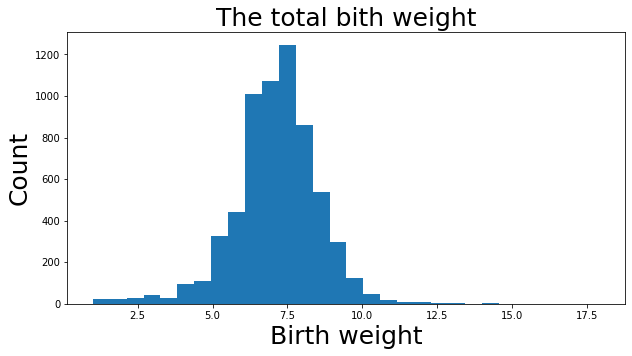

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(birth_weight.dropna(), bins=30)
plt.title("The total bith weight", fontsize=25)
plt.xlabel("Birth weight", fontsize=25)
plt.ylabel("Count", fontsize=25)
plt.show()

##### The distribution looks like a little **bell-shaped-curve**. But the ***tail is longer on the left*** than on the right, which means that there are ***more light babies*** than ***heavy babies***.
##### That makes sense because the distribution includes some babies that were born ***preterm***.
##### The common duration for pregnancy is ***39 weeks***, which is ***full term***, But ***preterm*** is usually defined to be less than ***37 weeks***. 

[]

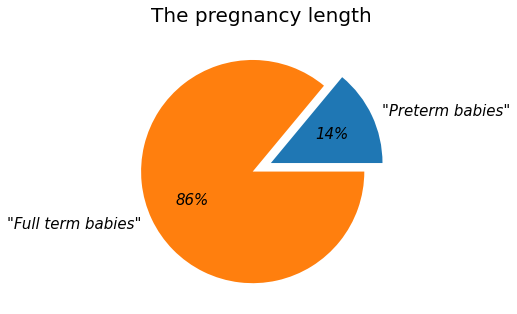

In [ ]:
# prglengh column contains the pregnancy length in weeks.
# we filter our dataset by which babies is preterm and full term
# it returns a boolean series with true for preterm and leas that 37 and false for full term.

length= data['prglngth']
preterm = length < 37
full_term = length >= 37

plt.figure(figsize=(5,7))
plt.title("The pregnancy length", fontsize=20)
plt.pie([preterm.sum(), full_term.sum()], 
        labels=['"Preterm babies"', '"Full term babies"'], 
        autopct="%1.f%%", 
        explode=[0.09, 0.09],
        textprops={"fontsize":15, "style":"italic"} )
plt.plot()

In [ ]:
# compute the average birth weight of preterm babies
preterm_weight = birth_weight[preterm]
print("The average weight of preterm babies  : ", preterm_weight.mean())

# isolate the "full term" babies and get their weights.
full_term_weight = birth_weight[~preterm]
print("The average weight of full_term babies: ", full_term_weight.mean())

The average weight of preterm babies  :  5.605014124293786
The average weight of full_term babies:  7.373673133235725


#####  Not surprisingly, on average ***full term babies*** are heavier than ***preterm*** babies. 
##### That eplains why we have ***more ligth birth weight babies than heavy babies*** in our dataset.
##### Let's find out more about the ***relationship between pergnancy length and birth weigh***.

In [ ]:
relation = data.dropna(subset=["prglngth", "birth_weight"])
#create a object from linregress, which in it turn get the liner relationship bteween two features.
res = linregress(relation["prglngth"], relation["birth_weight"])
print(res)

LinregressResult(slope=0.2897812074047899, intercept=-4.025127150685331, rvalue=0.5347122164984471, pvalue=0.0, stderr=0.005748309747535064)


#### The slope is about 0.289 pound per week, which means that we expect babies with one more week longer in pregnancy length to be almost 0.289 pound heavier.

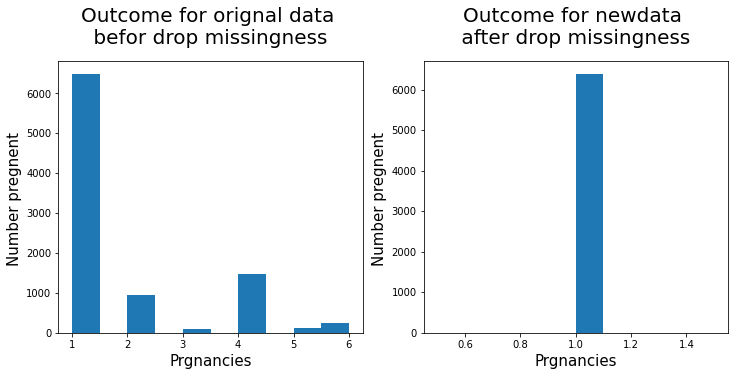

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(newdata["outcome"])
plt.title("Outcome for orignal data \n befor drop missingness ", y=1.04, fontsize=20)
plt.xlabel("Prgnancies", fontsize=15)
plt.ylabel("Number pregnent ", fontsize=15)

plt.subplot(1,2,2)
plt.hist(data["outcome"])
plt.title("Outcome for newdata \n after drop missingness ", y=1.04, fontsize=20)
plt.xlabel("Prgnancies", fontsize=15)
plt.ylabel("Number pregnent ", fontsize=15)
plt.show()

##### Most of smaples in our dataset have been pregnant for just ***once*** a little ***with 5,6 times***.
##### but as we can see after we drop missingness, cases with **many time prgnancies** does't exist anymore, wich means that missingness are with many time prgnancies, and this ****emphasis our assumption about miscarriage***, that we mentioned before.

In [ ]:
### 'nbrnaliv': contains the number of babies born alive at the end of a pregnancy.
data['nbrnaliv'].value_counts()

1.0    6286
2.0      99
3.0       5
8.0       1
Name: nbrnaliv, dtype: int64

##### the value ***8*** appears ***once***, It does't make any sense the maxmimum number of pregnancies is 6. ***how 8 comes in !!***
##### If you consult ***the codebook***, you'll see that this value indicates that the respondent ***refused to answer the question***. 
##### So, let's replace the value 8 with NaN.

In [ ]:
data['nbrnaliv'].replace(8, np.nan, inplace=True)

# Filter single births
single = data['nbrnaliv'] == 1

# Compute birth weight for single full-term babies
single_full_term_weight = birth_weight[single & full_term]
print('Single full-term mean weight :', single_full_term_weight.mean())

# Compute birth weight for multiple full-term babies
mult_full_term_weight = birth_weight[~single & full_term]
print('Multiple full-term mean weight :', mult_full_term_weight.mean())

Single full-term mean weight : 7.387006366488282
Multiple full-term mean weight : 5.768055555555556


##### Intersting, The average weight of ***single full term babies*** are heavier than ***multiple full term***.

##### the ***agecon*** column encodes the respondent's age at conception, and ***agepreg*** the respondent's age at the end of the pregnancy.
##### Both ***agecon*** and ***agepreg*** are recorded as integers with two implicit decimal places, so the value 2575 means that the respondent's age was 25.75.

In [ ]:
# Select the columns and divide by 100
agecon = data['agecon'] / 100
agepreg = data['agepreg'] / 100

# Compute the difference
preg_length = agepreg - agecon

# Compute summary statistics
print(preg_length.describe())

count    9109.000000
mean        0.552069
std         0.271479
min         0.000000
25%         0.250000
50%         0.670000
75%         0.750000
max         0.920000
dtype: float64


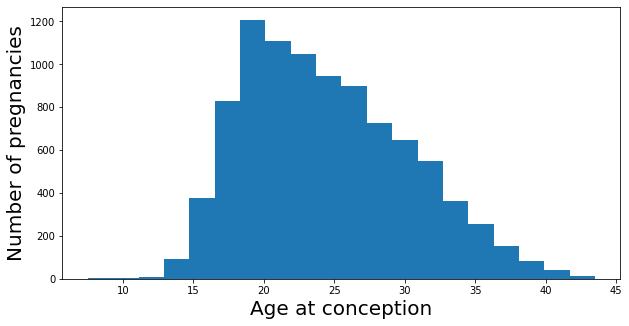

In [ ]:
plt.figure(figsize=(10,5))
# Plot the histogram
plt.hist(agecon, bins=20)

# Label the axes
plt.xlabel('Age at conception', fontsize=20)
plt.ylabel('Number of pregnancies', fontsize=20)

# Show the figure
plt.show()